# Problem 6

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

%matplotlib inline

already_loaded = 1

In [2]:
if already_loaded:
    openml_mnist = pickle.load(open('cifar.pkl', 'rb'))
else:
    openml_mnist = fetch_openml('CIFAR_10_small', as_frame=True)
    pickle.dump(openml_mnist, open('cifar.pkl', 'wb'))

First of all, we split the dataset into training, validation and test sets. We also perform preprocessing on the training and validation sets.

In [3]:
X_full = openml_mnist.data.values
Y_full = openml_mnist.target.values.to_numpy(dtype=np.int)

X_train_all, X_test, Y_train_all, Y_test = train_test_split(X_full, Y_full, test_size=0.25)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_all, Y_train_all, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

X_train = torch.FloatTensor(X_train).view(-1,3,32,32)
X_valid = torch.FloatTensor(X_valid).view(-1,3,32,32)
Y_train = torch.LongTensor(Y_train)
Y_valid = torch.LongTensor(Y_valid)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_valid, Y_valid)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)

Here, we define the function to be used for training our network. The general procedure is the following:
- Make predictions on each batch of the training set.
- Update the parameters using backpropagation for each batch.
- At the end of each epoch, calculate the validation loss of the network.

In [4]:
def fit(model, train_dl, val_dl, opt, loss_func, epochs=50, plot=False, verbose=False):
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(dev)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_dl:
            xb = xb.to(dev)
            yb = yb.to(dev)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_losses.append((loss.item()*len(xb),len(xb)))

        losses, elems = zip(*train_losses)
        train_losses_per_epoch.append(np.sum(losses)/np.sum(elems))

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(dev)
                yb = yb.to(dev)
                loss = loss_func(model(xb), yb)
                val_losses.append((loss.item()*len(xb),len(xb)))
                

        losses, elems = zip(*val_losses)
        val_losses_per_epoch.append(np.sum(losses)/np.sum(elems))

        if verbose:
            print('Epoch {0:}: Training loss = {1:.4f}, Validation Loss = {2:.4f}'.format(epoch+1, train_losses_per_epoch[-1], val_losses_per_epoch[-1]))
        
        if epoch+1 == epochs:
            with torch.no_grad():
                preds = []
                labels = []
                for xb, yb in val_dl:
                    xb = xb.to(dev)
                    preds.append(model(xb).cpu().numpy())
                    labels.append(yb.numpy())
                print('Accuracy: {0:.3f}'.format(accuracy_score(np.concatenate(labels), np.argmax(np.concatenate(preds),axis=1))))

    if plot:
        plt.figure()
        plt.plot(np.arange(1,epochs+1), train_losses_per_epoch, 'b--', label='Training Loss')
        plt.plot(np.arange(1,epochs+1), val_losses_per_epoch, 'g-', label='Validation Loss')
        plt.legend()
        plt.grid()
        plt.show()

We first examine the results we can obtain using the same CNN we used for MNIST.

In [5]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)

opt = optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()
fit(model, train_dl, val_dl, opt, loss, epochs=50, verbose=True)

Epoch 1: Training loss = 2.1495, Validation Loss = 1.9887
Epoch 2: Training loss = 1.8808, Validation Loss = 1.8571
Epoch 3: Training loss = 1.7585, Validation Loss = 1.6872
Epoch 4: Training loss = 1.7041, Validation Loss = 1.6864
Epoch 5: Training loss = 1.6643, Validation Loss = 1.6629
Epoch 6: Training loss = 1.6245, Validation Loss = 1.5952
Epoch 7: Training loss = 1.5944, Validation Loss = 1.5727
Epoch 8: Training loss = 1.5719, Validation Loss = 1.6143
Epoch 9: Training loss = 1.5508, Validation Loss = 1.5517
Epoch 10: Training loss = 1.5267, Validation Loss = 1.5188
Epoch 11: Training loss = 1.5058, Validation Loss = 1.5421
Epoch 12: Training loss = 1.4836, Validation Loss = 1.4954
Epoch 13: Training loss = 1.4708, Validation Loss = 1.5003
Epoch 14: Training loss = 1.4530, Validation Loss = 1.4547
Epoch 15: Training loss = 1.4431, Validation Loss = 1.5363
Epoch 16: Training loss = 1.4319, Validation Loss = 1.4959
Epoch 17: Training loss = 1.4085, Validation Loss = 1.5511
Epoch 

We see that, even with no fine tuning at all, we can achieve better results than the previous methods. We can attempt to change the model in various ways, for example via adding one more convolutional layer:

In [6]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(10, 10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)

opt = optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()
fit(model, train_dl, val_dl, opt, loss, epochs=50, verbose=True)

Epoch 1: Training loss = 2.1583, Validation Loss = 2.0202
Epoch 2: Training loss = 1.9247, Validation Loss = 1.8361
Epoch 3: Training loss = 1.7959, Validation Loss = 1.7457
Epoch 4: Training loss = 1.7131, Validation Loss = 1.6366
Epoch 5: Training loss = 1.6447, Validation Loss = 1.5953
Epoch 6: Training loss = 1.5844, Validation Loss = 1.5754
Epoch 7: Training loss = 1.5368, Validation Loss = 1.5127
Epoch 8: Training loss = 1.4973, Validation Loss = 1.4881
Epoch 9: Training loss = 1.4590, Validation Loss = 1.5595
Epoch 10: Training loss = 1.4222, Validation Loss = 1.5019
Epoch 11: Training loss = 1.4039, Validation Loss = 1.4132
Epoch 12: Training loss = 1.3801, Validation Loss = 1.4014
Epoch 13: Training loss = 1.3586, Validation Loss = 1.4783
Epoch 14: Training loss = 1.3446, Validation Loss = 1.3913
Epoch 15: Training loss = 1.3276, Validation Loss = 1.3757
Epoch 16: Training loss = 1.3114, Validation Loss = 1.4116
Epoch 17: Training loss = 1.2898, Validation Loss = 1.4965
Epoch 

We can see that this enhances the results. Other possible approaches are to fine tune the number of output channels of each layer, the kernel sizes etc.

We shall now test the effect of learning rate on the model:

Accuracy: 0.514


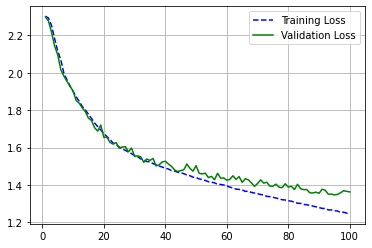

Accuracy: 0.481


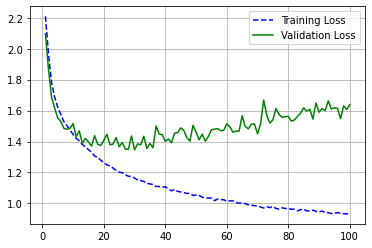

Accuracy: 0.427


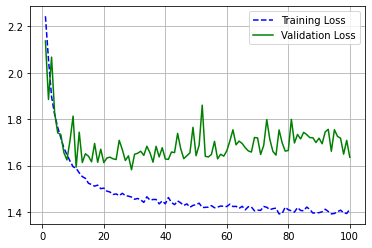

In [7]:
for lr in [0.01,0.1,0.5]:
    model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(10, 10, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten()
    )

    opt = optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    fit(model, train_dl, val_dl, opt, loss, epochs=100, plot=True)

We can see that, for a low learning rate, the model converges slowly, but reaches a lower loss. As the learning rate grows, the model converges faster, but becomes more unstable (and diverges in regards to the validation loss).

As for the effects of momentum, we have the following:

Accuracy: 0.463


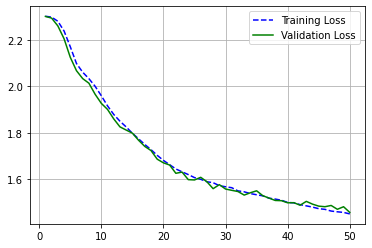

Accuracy: 0.491


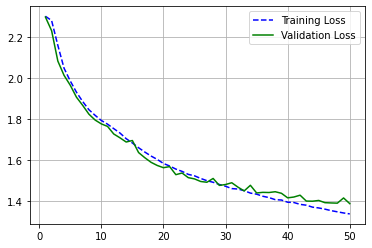

Accuracy: 0.479


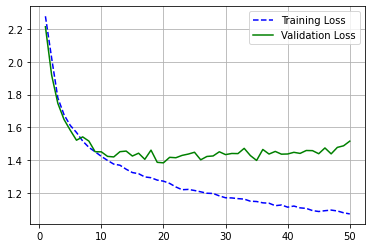

In [8]:
for momentum in [0,0.3,0.9]:
    model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(10, 10, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten()
    )

    opt = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
    loss = nn.CrossEntropyLoss()
    fit(model, train_dl, val_dl, opt, loss, epochs=50, plot=True)

We can see that increasing the momentum leads to better accuracy, though after some point it leads to the model overfitting.

We can now perform one more extension to the above models. In particular, we change the average pooling to max pooling (taking the highest element in windows of the outputs of the convolutional layers) and using a final linear layer for the classification.

Accuracy: 0.531


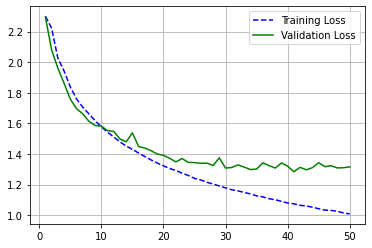

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(10, 10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(4),
    nn.Flatten(),
    nn.Linear(160,10)
)

opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.3)
loss = nn.CrossEntropyLoss()
fit(model, train_dl, val_dl, opt, loss, epochs=50, plot=True)

We see that this further enhances the results. This can also be seen in the test set, as follows:

In [10]:
scaler = StandardScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test = scaler.transform(X_test)

X_train_all = torch.FloatTensor(X_train_all).view(-1,3,32,32)
X_test = torch.FloatTensor(X_test).view(-1,3,32,32)
Y_train_all = torch.LongTensor(Y_train_all)
Y_test = torch.LongTensor(Y_test)

train_ds = TensorDataset(X_train_all, Y_train_all)
test_ds = TensorDataset(X_test, Y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(10, 10, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(4),
    nn.Flatten(),
    nn.Linear(160,10)
)

opt = optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()
fit(model, train_dl, test_dl, opt, loss, epochs=50, plot=False)

Accuracy: 0.560


This can be further enhanced via more extensive tuning of the hyperparameters.